せっかくだし泥臭くスクラッチで組んでみないか？

In [1]:
import mxnet as mx
from mxnet import nd, autograd
import numpy as np

# Linear regression
データのあつまりをX, ターゲットの値をy  
wとbをうまく選んでX[i]とy[i]が程よくマッチするようにする  
数式で表すと
$$
\hat{y} = X \cdot w + b
$$
これについて
$$
\sum_{i=1}^{n} \left( \hat{y_i} - y_i \right)^2
$$
を最小化することを目指す

線形回帰は使い古されたモデルだが、もっともシンプルなNNの一種となる  
通常NNはエッジからの値の層への集約を行い、ノードに対しては重み付けと活性化関数が付与されることになる  
線形回帰は2層、インプットとアウトプット、活性化関数は判別の関数。

単純化のためデータは合成する。ランダムにX[i]を生成、ラベルにはy[i] = 2 * X[i][0]- 3.4 * X[i][1] + 4.2 + noise を利用（ノイズは0から1のガウシアンノイズ）
数学的には
$$
y = X \cdot w + b + \eta, for \eta ~ N(0, \sigma^2)
$$
と表される

In [2]:
X = np.random.randn(10000,2)  # 10000行2列
y = 2* X[:,0] - 3.4 * X[:,1] + 4.2 + .01 * np.random.normal(size=10000)

In [3]:
print(X[0])
print(y[0])
print(X)
print(X[:,0]) # 0列目だけスライス

[ 0.73814795  1.0124121 ]
2.22733224807
[[ 0.73814795  1.0124121 ]
 [-1.12270754  0.88025542]
 [ 1.0905253   0.58044741]
 ..., 
 [-0.63403713  0.35103897]
 [ 1.29011114 -0.95275817]
 [ 0.09297999 -0.04272793]]
[ 0.73814795 -1.12270754  1.0905253  ..., -0.63403713  1.29011114
  0.09297999]


各x0, x1に対応する理想の値は、ある点に対しては

In [4]:
print(2 * X[0,0] - 3.4 * X[0,1] + 4.2)

2.23409475122


X1に対するyの値をmatplotlibで描画すると

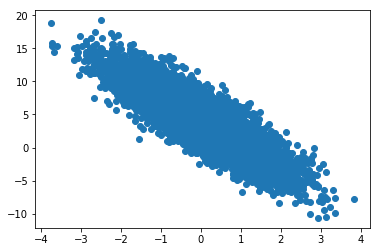

In [5]:
import matplotlib.pyplot as plt
plt.scatter(X[:,1],y)
plt.show()

# Data iterators
NNでデータを扱うとき、データポイントを素早くインクリメントしていかなくてはならない
またシャッフルのためバッチサイズkを取り出す必要もある  
MXNetではデータのフェッチや操作にいい感じのユーティリティが存在、今回はシンプルな`NDArrayIter`クラスを利用

In [6]:
batch_size = 4
train_data = mx.io.NDArrayIter(X, y, batch_size, shuffle=True)

一度NDArrayIterで初期化すれば（今回は`train_data`）、`train_data.next()`で簡単にバッチを取得できる。`batch.data`はインプットのリストを取得、今回はX１つのみなので、単に`batch.data[0]`を取得

In [7]:
batch = train_data.next()
print(batch.data[0])


[[ 0.23309712  1.44885159]
 [ 1.8167063  -0.21678253]
 [ 0.15461132  0.43277356]
 [-1.81496298  0.10680802]]
<NDArray 4x2 @cpu(0)>


ラベルの取得も可能
> この場合多分第二引数に与えられてるyをラベルとしてみてるんだろう

In [8]:
print(batch.label[0])


[-0.26473054  8.58372784  3.04061389  0.22270079]
<NDArray 4 @cpu(0)>


`train_data` は通常のpythonのリストと同様にイテレートできる

In [9]:
counter = 0
train_data.reset()
for i, batch in enumerate(train_data):
    counter += 1
print(counter)

2500


`train_data.reset()`はイテレータに、次の試行に備えてデータのリシャッフルを行うことを知らせる

In [10]:
# リセットを行わない場合
counter = 0
for i, batch in enumerate(train_data):
    counter += 1
print(counter)

0


# Model parameters
パラメータに初期値をセットしメモリの確保

In [11]:
w = nd.random_normal(shape=(2,1))
b = nd.random_normal(shape=1)

params = [w, b]

これらのパラメータをデータにフィットするようにアップデートをかけていく。このとき、パラメータについての損失関数の勾配(多次元の導関数)を算出することになる。 
この損失を減らす方向にそれぞれのパラメータについてアップデートをかけていくことになるが、ひとまずそれぞれの勾配に対してメモリを割り当てる

In [12]:
for param in params:
    param.attach_grad()

# Neural networks
次にモデルを定義する。今回は単純かつ便利なNNである線形モデル  
シンプルに重みをかけてオフセットbを加える

In [13]:
def net(X): 
    return nd.dot(X, w) + b

# Loss function
トレーニングはより良い結果を目指してモデルを構築するが、良いとは何かを定義しなくては始まらない  
今回は予測と実際の値の平方距離を利用する

In [14]:
def square_loss(yhat, y): 
    return nd.mean((yhat - y) * (yhat-y))

# Optimizer
線形回帰には理想的な解決法があるが、実際のモデルは分析的に解けないものが大半となる。この解決法がSGD(確率的勾配降下法)　 
それぞれのステップで、データセットからランダムに抽出されたバッチから、重みに対する損失関数の勾配を見積る。そしてパラメータを、損失を減らす方向へ少しだけアップデートする。  
このステップの幅は学習率（`lr`）で決められる

In [15]:
def SGD(params, lr):    
    for param in params:
        param[:] = param - lr * param.grad

# Execute training loop
これで全ての要素が揃ったので、トレーニングループを書いて繋いでいく。 
最初に`epoch`を定義する。エポックとは、データセットに対し何度試行を行うかの単位となる。  
そしてそれぞれの試行で、`train_data`をイテレートし、値とそれに対するラベルのバッチを取得する。  
それぞれのバッチでは、このようなプロセスを経る 
- 順方向に試行を行い予測(`yhat`)と損失(`loss`)を生成
- 勾配を逆方向に試行を行い算出(`loss.backward()`)
- パラメータをSGD Optimizerでアップデート

In [16]:
epochs = 2
ctx = mx.cpu()
moving_loss = 0.

for e in range(epochs):
    train_data.reset()
    for i, batch in enumerate(train_data):  # ここからバッチ処理
        data = batch.data[0].as_in_context(ctx)
        label = batch.label[0].as_in_context(ctx).reshape((-1,1)) # 要素数×1の行列に変換
        with autograd.record():  # 計算グラフ利用開始
            output = net(data)  #  順方向
            loss = square_loss(output, label)   # 損失計算
        loss.backward()  # 逆方向（勾配計算）
        SGD(params, .001)  # W, bの値をずらす
        
        ##########################
        #  Keep a moving average of the losses
        ##########################
        if i == 0:
            moving_loss = np.mean(loss.asnumpy()[0])
        else:
            moving_loss = .99 * moving_loss + .01 * np.mean(loss.asnumpy()[0])
            # 謎計算、誤差の処理？
            
        if i % 500 == 0:
            print("Epoch %s, batch %s. Moving avg of loss: %s" % (e, i, moving_loss))

Epoch 0, batch 0. Moving avg of loss: 10.0031
Epoch 0, batch 500. Moving avg of loss: 7.0615891301
Epoch 0, batch 1000. Moving avg of loss: 0.968474248144
Epoch 0, batch 1500. Moving avg of loss: 0.134010479594
Epoch 0, batch 2000. Moving avg of loss: 0.0162489220546
Epoch 1, batch 0. Moving avg of loss: 0.00101114
Epoch 1, batch 500. Moving avg of loss: 0.000449684360328
Epoch 1, batch 1000. Moving avg of loss: 0.000144372348542
Epoch 1, batch 1500. Moving avg of loss: 0.000108698656435
Epoch 1, batch 2000. Moving avg of loss: 0.000106613631098


In [17]:
print(w) # Ans: 2, -3.4
print(b)  # Ans: 4.2


[[ 2.00002193]
 [-3.39963365]]
<NDArray 2x1 @cpu(0)>

[ 4.1997509]
<NDArray 1 @cpu(0)>


（参考）reshape(-1)の動作：要素数を保ったまま行か列どちらかに寄せるのに利用する模様

In [18]:
a = nd.array([[1,2,3],[4,5,6]])

In [19]:
a.reshape((-1,1))


[[ 1.]
 [ 2.]
 [ 3.]
 [ 4.]
 [ 5.]
 [ 6.]]
<NDArray 6x1 @cpu(0)>